# Libraries

In [19]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb

%matplotlib inline

# Helper Functions: Graphs

In [2]:
def plot_auc(name_list,fpr_list,trp_list,roc_auc_list,color_list):
    plt.clf()
    plt.figure(figsize = (9, 7))
    for i in range(len(fpr_list)):
        plt_label = f"ROC of {name_list[i]} Curve (AUC = %0.4f)"
        plt.plot(fpr_list[i], tpr_list[i], color=color_list[i],lw=2, label= plt_label % roc_auc_list[i])
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 11
    plt.title('ROC Curve')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_prob_histogram(name_list,prob_list, color_list):
    fig, axs = plt.subplots(len(name_list), figsize=(10,10))
    for i in range(len(name_list)):
        axs[i].hist(prob_list[i][:,1], color= color_list[i])
        axs[i].set_title(f"{name_list[i]} Prob Distribution")
        axs[i].set(xlabel='Probability', ylabel='Number of Classifications')
    fig.tight_layout()
    plt.show()

def plot_acc(name_list,score_list,color_list):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Model Score')
    ax.set_xlabel('Methodology')
    ax.set_ylabel('Accuracy Score')
    ax.bar(name_list,score_list)
    for i in range(len(color_list)):
        ax.get_children()[i].set_color(color_list[i])
    for i in range(len(name_list)):
        print(f'{name_list[i]} Accuracy: {np.round(score_list[i] * 100, 3)}%')
    
    plt.show()

# Data Exploration

Data from GiveMeSomeCredit: https://www.kaggle.com/c/GiveMeSomeCredit

In [3]:
df = pd.read_csv('cs-training.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(f'Row, columns: {df.shape}')
df.head()

Row, columns: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [5]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [6]:
y = df['SeriousDlqin2yrs']
X = df.drop(columns=['SeriousDlqin2yrs'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model of Choice: XGBoost

In [14]:
model = xgb.XGBClassifier()

# Missing Values

## Methodology Comparison

In [8]:
missing_imputter_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
missing_imputter_median = SimpleImputer(missing_values=np.nan, strategy='median')
missing_imputter_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
missing_iterative_imputter = IterativeImputer(random_state=0)

In [9]:
methodology = [missing_imputter_mean,missing_imputter_median,missing_imputter_freq,missing_iterative_imputter]

## Pipeline

In [16]:
color_list = ['red', 'blue', 'green', 'orange']
name_list = ['mean', 'median', 'freq', 'imputter']
fpr_list = []
tpr_list = []
roc_auc_list = []
probs_list = []
score_list = []

for m in methodology:
    pipe = Pipeline([('MissingValues', m),('clf', model)])
    pipe.fit(X_train,y_train)
    probs = pipe.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probs[:,1])
    roc_auc = auc(fpr, tpr)
    score = pipe.score(X_train, y_train)
    probs_list.append(probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    score_list.append(score)

## Graph

<Figure size 432x288 with 0 Axes>

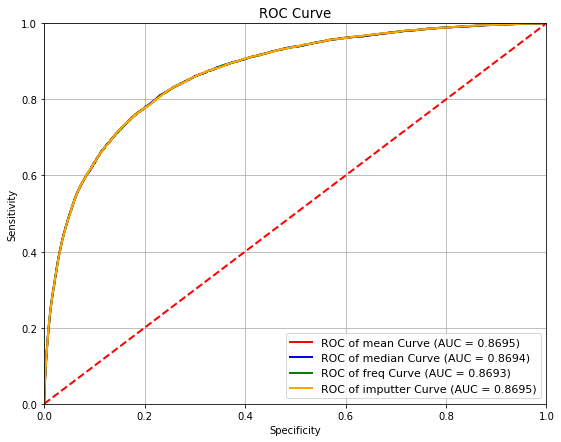

In [11]:
plot_auc(name_list,fpr_list,tpr_list,roc_auc_list,color_list)

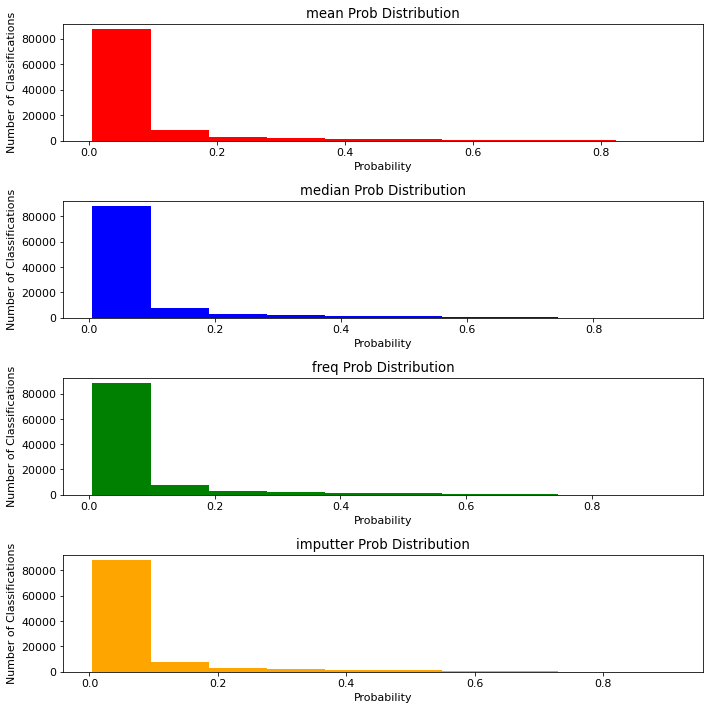

In [12]:
plot_prob_histogram(name_list,probs_list,color_list)

mean Accuracy: 93.791%
median Accuracy: 93.809%
freq Accuracy: 93.802%
imputter Accuracy: 93.823%


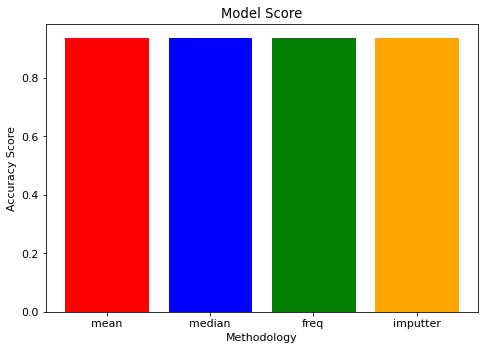

In [13]:
plot_acc(name_list,score_list,color_list)

Missing Value Selection: Iterative Imputter - highest in terms of AUC and Accuracy.

# Scaling Features

## Methodology Comparison

In [26]:
maxabs_transformer = preprocessing.MaxAbsScaler()
minmax_transformer = preprocessing.MinMaxScaler()
normal_trasnformer = preprocessing.Normalizer()
robust_transformer = preprocessing.RobustScaler()
standard_transformer = preprocessing.StandardScaler()

In [25]:
methodology = [maxabs_transformer,minmax_transformer,normal_trasnformer,robust_transformer,standard_transformer]

## Pipeline

In [28]:
color_list = ['red', 'blue', 'green', 'orange', 'purple']
name_list = ['MaxAbs', 'MinMax', 'Normal', 'Robust', 'Standard']
fpr_list = []
tpr_list = []
roc_auc_list = []
probs_list = []
score_list = []

for m in methodology:
    pipe = Pipeline([('MissingValues', missing_iterative_imputter),
                     ('ScalingFeatures', m),
                     ('clf', model)])
    pipe.fit(X_train,y_train)
    probs = pipe.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probs[:,1])
    roc_auc = auc(fpr, tpr)
    score = pipe.score(X_train, y_train)
    probs_list.append(probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    score_list.append(score)

## Graph

<Figure size 432x288 with 0 Axes>

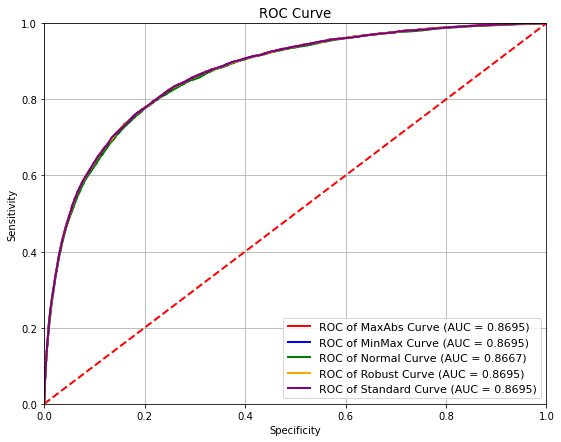

In [29]:
plot_auc(name_list,fpr_list,tpr_list,roc_auc_list,color_list)

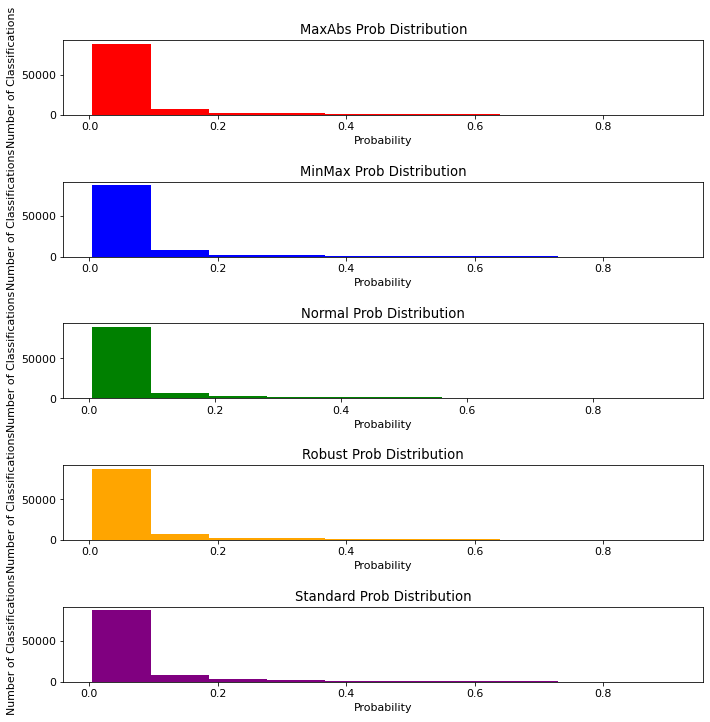

In [30]:
plot_prob_histogram(name_list,probs_list,color_list)

MaxAbs Accuracy: 93.823%
MinMax Accuracy: 93.823%
Normal Accuracy: 93.737%
Robust Accuracy: 93.823%
Standard Accuracy: 93.807%


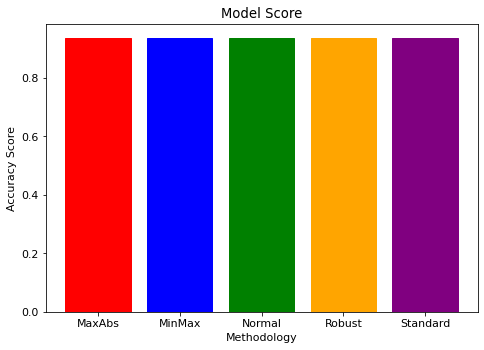

In [31]:
plot_acc(name_list,score_list,color_list)